In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

In [ ]:
# target 값 count 대여횟수
bike_df=pd.read_csv('data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

In [ ]:
# 날짜 objest --> pandas datetime 형으로  --> 년,월,일, 시간 추출

bike_df['datetime']=bike_df['datetime'].apply(pd.to_datetime)
bike_df['year']=bike_df['datetime'].apply(lambda x : x.year)
bike_df['month']=bike_df['datetime'].apply(lambda x : x.month)
bike_df['day']=bike_df['datetime'].apply(lambda x : x.day)
bike_df['hour']=bike_df['datetime'].apply(lambda x : x.hour)

In [ ]:
# 컬럼 삭제-날짜, 대여횟수(등록 유무) -상관도가 높아 분석 잘 안됨
bike_df.drop(['datetime','registered','casual'], axis=1, inplace=True)

In [ ]:
# 시각화
fig, axis=plt.subplots(figsize=(12,6),ncols=4, nrows=2)
cat_f=['season','holiday','workingday','weather','year','month','day','hour']
for i, feature in enumerate(cat_f):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=bike_df, ax=axis[row][col])
plt.tight_layout

In [153]:
# (미리 만들어놓음) 예측성능 특정 함수 

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

# 1. RMSLE(root_mean_squar_log_error) 함수
def rmsle (y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle
# 2. RMSE(root_mean_squared_error) 함수
def rmse(y, pred): 
    return np.sqrt(mean_squared_error(y, pred))

# 3. 모든 예측성능 측정 함수
def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    r2_val=r2_score(y,pred)
    print('RMSLE: {0:.2f}, RMSE: {1:.2f}, MAE: {2:.2f}, R2: {3:.2f}'.format(rmsle_val,rmse_val, mae_val, r2_val)) 

ImportError: cannot import name 'cross_val_score' from 'sklearn.metrics' (C:\Users\KEI\anaconda3\Lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
# 전처리-정규분포인지, 원-핫인코딩
# 회귀모델로 확인작업-회귀예측

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'], axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test, pred)


In [ ]:
# 실제값과 예측값의 차이 확인: 

def get_top_error_data(y_test, pred, n_top=5):
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['pred_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count'] - result_df['pred_count'])
    print(result_df.sort_values('diff', ascending=False)[:n_top])
    
get_top_error_data(y_test, pred, n_top=5)

## 실제 대여값과 비교하면 예측오류가 큼 -> target값이 정규분포가 아님: 왜곡되었는지 검토필요

In [ ]:
# target값 살펴보기
y_target.hist()

In [ ]:
# 타겟값을 넘파이의 log1p()로 변경 --> 학습, 예측 --> expm1()로 원상복구 -> 평가

y_target_log=np.log1p(y_target)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

y_test_exp=np.expm1(y_test)
pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

In [ ]:
# 개별 featuer의 회귀계수값 시각화 --> 인코딩 작업
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

# 선형회귀에서는 회귀계수를 연산할때 숫자값(범주형-year, month 등)에 영향 받음--> 인ㄴ코딩해야

In [106]:
# 범주형 변수들 원핫인코딩

X_features_ohe=pd.get_dummies(X_features,
                              columns=['season','holiday','workingday','weather','year','month','day','hour'])
X_features_ohe.shape

(10886, 73)

In [ ]:
# 인코딩된 피처데이터로 학습/예측
X_train, X_test, y_train, y_test=train_test_split(X_features_ohe, y_target, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터세트를 입력하면 성능평가 수치 반환
def get_model_predict(model, X_train, X_test,  y_train, y_test, is_expm1=False):
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print(model.__class__.__name__)
    evaluate_regr(y_test, pred)
    
# 모델별로 평가
lr_reg=LinearRegression()
rodge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, rodge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test,  y_train, y_test, is_expm1=True)

In [ ]:
## float64 에러 치료 -- 난 안됨

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(X_features_ohe)

<Axes: >

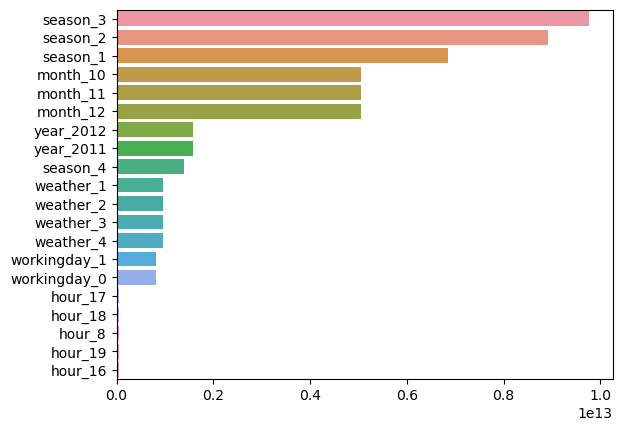

In [112]:
# 회귀계수 상위 20 그래프
coef=pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 각 모델별 연습문제/책

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

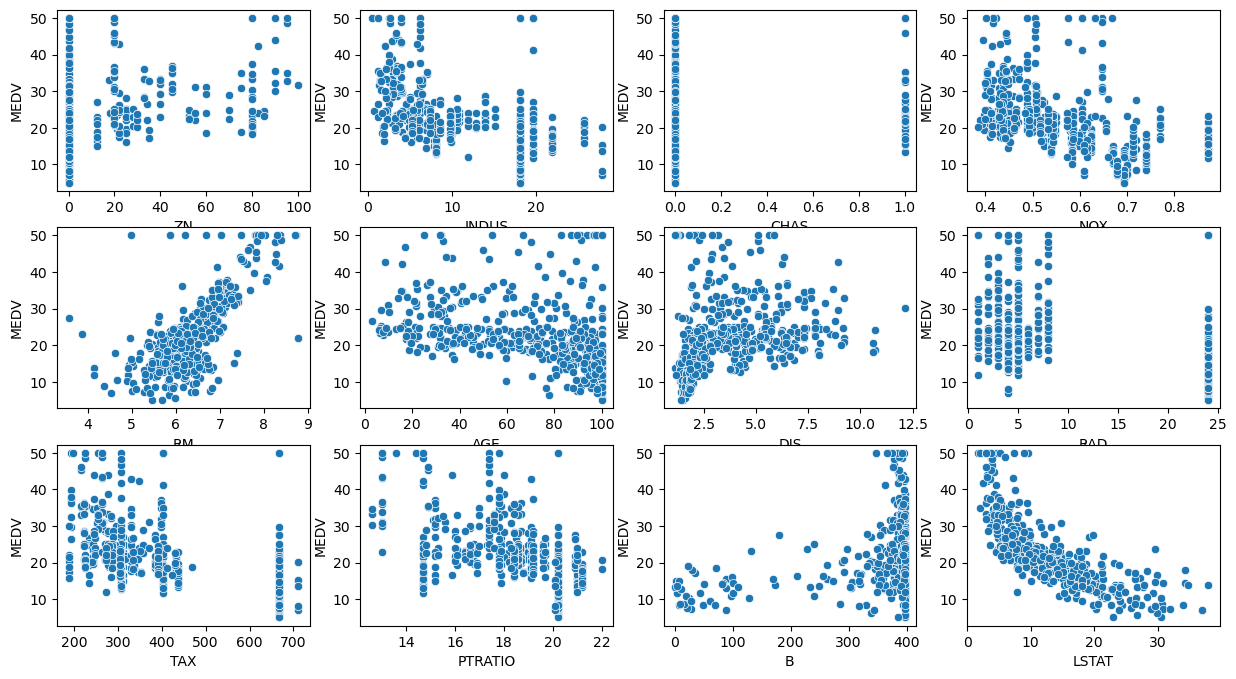

In [144]:
# 선형회귀
from sklearn import datasets

boston=pd.read_csv('data/boston.csv')

fig, axis=plt.subplots(figsize=(15,8),ncols=4, nrows=3)
cat_f=['ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
for i, feature in enumerate(cat_f):
    row = int(i/4)
    col = i%4
    sns.scatterplot(x=feature, y='MEDV', data=boston, ax=axis[row][col])
plt.tight_layout

In [145]:
X_features=boston.iloc[:,:-1]
y_target=boston.iloc[:,-1]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3 , random_state= 0)

lr=LinearRegression()
lr.fit(X_train,y_train)
pred=lr.predict(X_test)
mse=mean_squared_error(y_test, pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_test,pred)

print(f'MSE: {mse:.3f}, RMSE: {rmse:.3f}')

MSE: 27.196, RMSE: 5.215


In [147]:
def rmsle (y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred): 
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    r2_val=r2_score(y,pred)
    print('RMSLE: {0:.2f}, RMSE: {1:.2f}, MAE: {2:.2f}, R2: {3:.2f}'.format(rmsle_val,rmse_val, mae_val, r2_val)) 

In [148]:
evaluate_regr(y_test,pred)

RMSLE: 0.29, RMSE: 5.21, MAE: 3.61, R2: 0.67


In [150]:
coef=pd.Series(data=np.round(lr.coef_, 1), index=X_features.columns)
coef.sort_values(ascending=False)

RM          3.9
CHAS        2.5
RAD         0.2
ZN          0.0
INDUS       0.0
AGE        -0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.5
PTRATIO    -1.0
DIS        -1.5
NOX       -16.2
dtype: float64

In [ ]:
def get_top_error_data(y_test, pred, n_top=5):
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['pred_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count'] - result_df['pred_count'])
    print(result_df.sort_values('diff', ascending=False)[:n_top])

In [151]:
get_top_error_data(y_test,pred,n_top=5)

    real_count  pred_count  diff
1         50.0        24.0  26.0
37        50.0        25.0  25.0
96        13.8         0.0  13.8
25        23.1        10.0  13.1
53        42.8        30.0  12.8


In [158]:
from sklearn.model_selection import cross_val_score
neg_mse=cross_val_score(lr, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores=np.sqrt(-1* neg_mse)
print(np.mean(neg_mse),np.mean(rmse_scores))

-37.131807467699126 5.828658946215827


In [165]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge=Ridge(alpha=10)
neg_mse=cross_val_score(ridge, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores=np.sqrt(-1* neg_mse)
print(np.mean(neg_mse),np.mean(rmse_scores))

-33.395224459036555 5.51816628086897


In [162]:
alphas=[0,0.1,1,10,100]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    neg_mse_scores=cross_val_score(ridge,X_features, y_target, scoring='neg_mean_squared_error',cv=5)
    avg_rmse= np.mean(np.sqrt(-1*neg_mse_scores))
    print(f'alpha {alpha} 일 때 5fold의 평균 RMSE: {avg_rmse:.3f}')

alpha 0 일 때 5fold의 평균 RMSE: 5.829
alpha 0.1 일 때 5fold의 평균 RMSE: 5.788
alpha 1 일 때 5fold의 평균 RMSE: 5.653
alpha 10 일 때 5fold의 평균 RMSE: 5.518
alpha 100 일 때 5fold의 평균 RMSE: 5.330


In [170]:
# alpha값에 따는 회귀모델의 폴드평균 RMSE를 출력/회귀계수들을 Dataframe으로 반환
def get_linear_reg_eval(model_name, params=None, X_data=None, y_target=None, 
                        verbose=True, return_coeff=True):
    coeff_df=pd.DataFrame()
    if verbose : print(model_name)
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso' : model = Lasso(alpha=param)
        elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data, y_target, 
                                         scoring='neg_mean_squared_error', cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일때 5폴드 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        
        model.fit(X_data,y_target)
        if return_coeff:
            coeff=pd.Series(data=model.coef_, index=X_data.columns)
            colname='alpha:'+str(param)
            coeff_df[colname]=coeff
    return coeff_df

In [171]:
alphas=[0.07,0.1,0.5,1,3]
coeff_lasso_df=get_linear_reg_eval('Lasso',params=alphas, X_data=X_features, y_target=y_target)

Lasso
alpha 0.07일때 5폴드 평균 RMSE: 5.612
alpha 0.1일때 5폴드 평균 RMSE: 5.615
alpha 0.5일때 5폴드 평균 RMSE: 5.669
alpha 1일때 5폴드 평균 RMSE: 5.776
alpha 3일때 5폴드 평균 RMSE: 6.189


In [172]:
coeff_lasso_df

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
RM,3.789725,3.703202,2.498212,0.949811,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
DIS,-1.176583,-1.160538,-0.936605,-0.668790,-0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602


In [173]:
alphas=[0.07,0.1,0.5,1,3]
coeff_elastic_df=get_linear_reg_eval('ElasticNet',params=alphas, X_data=X_features, y_target=y_target)

ElasticNet
alpha 0.07일때 5폴드 평균 RMSE: 5.542
alpha 0.1일때 5폴드 평균 RMSE: 5.526
alpha 0.5일때 5폴드 평균 RMSE: 5.467
alpha 1일때 5폴드 평균 RMSE: 5.597
alpha 3일때 5폴드 평균 RMSE: 6.068


In [182]:
# 선형회귀모델의 스케일링,정규화 함수-중요 피처나 타겟값이 왜곡되었을때
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method=None,p_degree=None, input_data=None):
    if method =='Standard':
        scaled_data=StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data=MinMaxScaler().fit_transform(input_data)
    elif method =='Log':
        scaled_data=np.log1p(input_data)
    else: scaled_data=input_data
    
    if p_degree !=None:
        scaled_data=PolynomialFeatures(degree=p_degree, 
                                       include_bias=False).fit_transform(scaled_data)
    return scaled_data
#적용
X_data_scaled=get_scaled_data('Log',input_data=X_features)
alphas=[0.1,1,10,100]
get_linear_reg_eval('Ridge',params=alphas, X_data=X_data_scaled,y_target=y_target, verbose=False, return_coeff=False)

alpha 0.1일때 5폴드 평균 RMSE: 4.770
alpha 1일때 5폴드 평균 RMSE: 4.676
alpha 10일때 5폴드 평균 RMSE: 4.836
alpha 100일때 5폴드 평균 RMSE: 6.241


""
